In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import torch
import pickle
import datetime

from scipy.cluster.hierarchy import linkage
from itertools import combinations

from copy import deepcopy
from matplotlib import pyplot as plt
from collections import Counter
from io import StringIO
from Bio import Phylo

from VIPR import VIPR

import torch
import torch.nn as nn
torch.set_default_dtype(torch.float32)

# Set Parameters

In [17]:
dataset = "DS2" #["DS1","DS2","DS3","DS4","DS5","DS6","DS7","DS8","DS9","DS10","DS11","COV"]
method = "reinforce" #["reparam","reinforce","VIMCO"]
var_dist = "LogNormal"
alpha = 0.01 #[0.03,0.01,0.003,0.001]

rand_seed = 0

np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
data_file = '../dat/'+dataset+'/'+dataset+'.pickle'
out_file = '../results/'+dataset+'/'+dataset+'_'+var_dist+'_'+method+'_'+str(alpha)+'_'+str(rand_seed)+'_'+time+'.pickle'

In [18]:
# model parameters
var_dist = "LogNormal" #["LogNormal","Exponential","Mixture"]
pop_size = 5.0 # effective popuation size
rate = 1.0 # rate of evolution

# optimization parameters
batch_size = 10
max_iters = 10000 
max_time = 1.0 # HOURS
record_every = 100
test_batch_size = 100

# decay rate parameters
decay = "exp" # how to decay the learning rate
if decay == "linear":
    linear_decay = True
else:
    linear_decay = False
lr_decay_freq = 1
lr_decay_rate = 0.01**(1.0/max_iters)

# Import Data

In [19]:
with open(data_file, 'rb') as f:
    ds = pickle.load(f)
    
genomes = []
species = []
for key in ds:
    genomes.append(ds[key])
    species.append(key)

ntaxa = len(species)

# Initialize $\phi$

In [40]:
print("Initializing phi... \n")
treedata = ""
ntrees = 0
burnin = 10000

for i in range(10):
    tree_file = "../dat/"+dataset+"/"+dataset+"_fixed_pop_support_short_run_rep_%d.trees"%(i+1)
    with open(tree_file, "r") as file:
        for j,line in enumerate(file):
            if line.startswith("tree STATE") and j%10 == 0 and int(line.split("_")[1].split()[0]) > burnin:
                line = line[line.find('('):]
                line = line.replace("[&rate=1.0]","")
                line = line.replace("[&rate=0.001]","")
                treedata = treedata + line + "\n"
                ntrees += 1

phi0 = torch.zeros((2,ntaxa,ntaxa))
trees = Phylo.parse(StringIO(treedata), "newick")
dists = np.zeros((ntrees,ntaxa,ntaxa))

for i,tree in enumerate(trees):
    for j in range(ntaxa):
        for k in range(j):
            mrca = tree.common_ancestor(str(j+1),str(k+1))
            dists[i,j,k] = min(tree.distance(mrca,str(j+1)),tree.distance(mrca,str(k+1)))

for j in range(ntaxa):
    for k in range(j):
        phi0[0,j,k] = np.mean(dists[:,j,k])
        phi0[1,j,k] = np.var(dists[:,j,k])

# add random noise
if rand_seed > 0:
    phi0 = phi0 + torch.normal(mean=0.0,std=rand_seed*0.1,size=(2,ntaxa,ntaxa))

Initializing phi... 



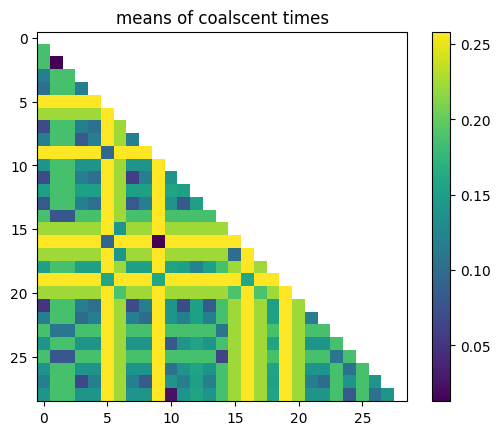

/var/folders/tr/5c181rvn0kv2qf36b5rlfbbr0000gn/T/ipykernel_6780/1270666240.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(var))#,vmin=-4,vmax=1)


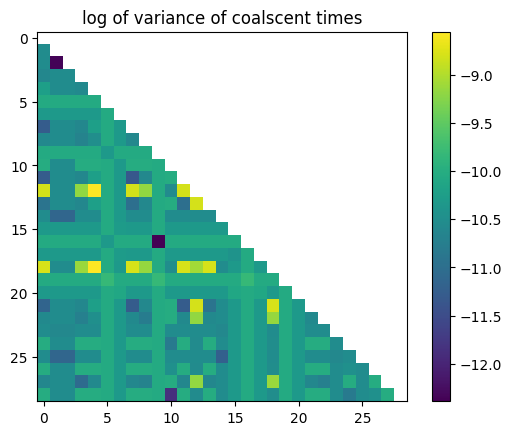

In [41]:
# plot phi0
m = deepcopy(phi0[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)#,vmin = -10, vmax = -4)
plt.title("means of coalscent times")
plt.colorbar()
plt.show()

var = deepcopy(phi0[1])
var[np.triu_indices(var.shape[0])] = np.nan
plt.imshow(np.log(var))#,vmin=-4,vmax=1)
plt.title("log of variance of coalscent times")
plt.colorbar()
plt.show()

# Train Model

In [42]:
optim = VIPR(genomes,phi0[0],phi0[1],var_dist=var_dist,
             phi_pop_size=torch.tensor([pop_size]),var_dist_pop_size="Fixed",
             theta_pop_size=None,prior_pop_size="Fixed",
             tip_dates=None,
             phi_rate=torch.tensor([rate]),var_dist_rate="Fixed",
             theta_rate=None,prior_rate="Fixed")

optim.learn(batch_size=batch_size,
            iters=max_iters,
            alpha=alpha,
            method=method,
            record_every=record_every,
            test_batch_size=test_batch_size,
            pop_size=pop_size,
            lr_decay_freq=lr_decay_freq,
            lr_decay_rate=lr_decay_rate,
            linear_decay=linear_decay,
            max_time=max_time)

iteration 0:(0.1s)
step size:  0.01
grad_norm estimate:  218.3554
ELBO estimate:  -26597.234375
100-sample ELBO estimate:  -26581.458984375



KeyboardInterrupt: 

In [ ]:
m = deepcopy(optim_nrm.phi[0].detach().numpy())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log coalscent times")
plt.colorbar()
plt.show()

var = deepcopy(optim_nrm.phi[1].detach().numpy())
var[np.triu_indices(var.shape[0])] = np.nan
plt.imshow(var)
plt.title("log of variance of log coalscent times")
plt.colorbar()
plt.show()

# Save Model

In [20]:
with open(out_file, 'wb') as file:
    pickle.dump(optim_nrm, file)